In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import time
import sqlite3

## Read and clean the sales data, then save in orders table

In [2]:
df = pd.read_csv('sales_data.csv', delimiter=',')
df

,order_id,customer_id,product_id,quantity,price,order_date
0,2334,5,40,3,35.60,2022-06-21
1,6228,8,13,7,36.52,2023-03-08
2,7784,9,44,4,46.56,2023-04-22
3,6588,5,26,1,15.87,2022-10-23
4,5910,8,32,10,77.00,2022-10-05
...,...,...,...,...,...,...
995,7967,6,34,10,14.44,2022-07-26
996,8308,6,16,1,61.38,2023-03-04
997,6938,4,18,7,62.96,2022-11-27
998,5921,9,37,9,52.89,2022-09-22


In [3]:
to_remove = df[df.groupby('order_id')['customer_id'].transform('nunique') > 1]
to_remove = to_remove.sort_values('order_id')
to_remove

,order_id,customer_id,product_id,quantity,price,order_date
473,1007,2,35,1,59.94,2023-05-02
779,1007,4,41,5,63.34,2022-10-08
819,1102,7,11,3,18.41,2022-08-12
733,1102,8,9,4,44.04,2022-10-13
211,1127,7,12,7,25.34,2023-04-25
...,...,...,...,...,...,...
26,9728,3,9,8,61.04,2022-12-16
335,9864,2,25,5,93.53,2022-07-24
566,9864,10,36,10,88.90,2022-12-26
378,9893,3,20,10,71.51,2022-09-29


In [4]:
mask = df.groupby('order_id')['customer_id'].transform('nunique') == 1
df = df[mask]
df.shape

(899, 6)

In [5]:
df.columns

Index(['order_id', 'customer_id', 'product_id', 'quantity', 'price',
       'order_date'],
      dtype='object')

In [7]:
conn = sqlite3.connect('my_database.db')
df.to_sql('orders', conn, if_exists='append', index=False)
conn.commit()
conn.close()

## Analyze the sales data

In [8]:
n = len(pd.unique(df['order_id']))
print(f'Number of unique order id values: {n}')

Number of unique order id values: 895


In [9]:
df.sort_values('order_id')

,order_id,customer_id,product_id,quantity,price,order_date
357,1009,3,46,8,49.49,2022-11-04
243,1010,2,1,6,31.79,2023-01-18
856,1011,10,23,6,71.55,2022-09-10
171,1012,9,6,6,29.16,2022-07-28
393,1013,5,30,8,47.12,2022-12-16
...,...,...,...,...,...,...
254,9980,8,41,2,47.00,2023-05-18
74,9983,9,8,9,98.42,2022-10-21
985,9985,6,2,10,24.47,2023-02-21
667,9989,5,49,6,16.67,2023-05-02


In [10]:
df.sort_values('product_id')

,order_id,customer_id,product_id,quantity,price,order_date
721,2934,7,1,5,47.03,2022-06-30
501,1609,2,1,3,15.54,2022-12-29
59,4032,10,1,2,18.63,2023-05-24
61,9065,8,1,2,29.32,2023-02-15
430,9070,3,1,4,70.36,2023-01-23
...,...,...,...,...,...,...
286,1744,7,50,1,20.19,2023-01-31
858,6048,2,50,8,37.62,2022-09-16
362,7422,1,50,1,27.68,2023-04-15
653,4444,2,50,10,32.02,2023-05-09


In [11]:
df.sort_values('order_date')

,order_id,customer_id,product_id,quantity,price,order_date
868,6812,2,36,3,76.58,2022-06-01
272,2190,5,5,1,89.76,2022-06-01
614,8050,4,17,8,50.25,2022-06-03
384,2873,8,45,1,27.91,2022-06-03
241,1084,10,17,6,32.93,2022-06-04
...,...,...,...,...,...,...
133,5332,8,20,1,31.50,2023-05-31
38,7231,1,38,7,95.54,2023-05-31
920,3205,9,1,6,73.63,2023-05-31
627,3455,4,44,4,77.00,2023-05-31


In [12]:
df = df.sort_values('customer_id')
df

,order_id,customer_id,product_id,quantity,price,order_date
687,5163,1,41,4,30.44,2022-10-10
402,3567,1,15,8,26.50,2023-03-03
662,1546,1,11,7,10.40,2023-03-25
118,8884,1,5,7,61.65,2022-09-19
398,2673,1,43,2,24.17,2023-02-04
...,...,...,...,...,...,...
771,9897,10,3,9,22.76,2023-05-04
182,3439,10,27,7,15.31,2022-08-12
186,7341,10,28,8,88.80,2022-06-17
96,1257,10,21,4,83.76,2023-02-09


## Get the User data from API

In [13]:
def fetch_user_data():
    url = "https://jsonplaceholder.typicode.com/users"
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        users = response.json()

        # Extract the required fields from each user
        extracted_data = []
        for user in users:
            data = {
                "id": user["id"],
                "name": user["name"],
                "username": user["username"],
                "email": user["email"],
                "lat": user["address"]["geo"]["lat"],
                "lng": user["address"]["geo"]["lng"]
            }
            extracted_data.append(data)
        
        return pd.DataFrame(extracted_data)
    else:
        print("Failed to retrieve data!")
        return None

In [14]:
user_data_df = fetch_user_data()
user_data_df

,id,name,username,email,lat,lng
0,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,-43.9509,-34.4618
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,-68.6102,-47.0653
3,4,Patricia Lebsack,Karianne,Julianne.OConner@kory.org,29.4572,-164.2990
4,5,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,-31.8129,62.5342
5,6,Mrs. Dennis Schulist,Leopoldo_Corkery,Karley_Dach@jasper.info,-71.4197,71.7478
6,7,Kurtis Weissnat,Elwyn.Skiles,Telly.Hoeger@billy.biz,24.8918,21.8984
7,8,Nicholas Runolfsdottir V,Maxime_Nienow,Sherwood@rosamond.me,-14.3990,-120.7677
8,9,Glenna Reichert,Delphine,Chaim_McDermott@dana.io,24.6463,-168.8889
9,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232


In [15]:
conn = sqlite3.connect('my_database.db')
user_data_df.to_sql('customers', conn, if_exists='append', index=False)
conn.commit()
conn.close()

## Merge sales data and user data

In [16]:
merged_df = df.merge(user_data_df, left_on="customer_id", right_on='id')
merged_df

,order_id,customer_id,product_id,quantity,price,order_date,id,name,username,email,lat,lng
0,5163,1,41,4,30.44,2022-10-10,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496
1,3567,1,15,8,26.50,2023-03-03,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496
2,1546,1,11,7,10.40,2023-03-25,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496
3,8884,1,5,7,61.65,2022-09-19,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496
4,2673,1,43,2,24.17,2023-02-04,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496
...,...,...,...,...,...,...,...,...,...,...,...,...
894,9897,10,3,9,22.76,2023-05-04,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232
895,3439,10,27,7,15.31,2022-08-12,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232
896,7341,10,28,8,88.80,2022-06-17,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232
897,1257,10,21,4,83.76,2023-02-09,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232


In [17]:
merged_df.columns

Index(['order_id', 'customer_id', 'product_id', 'quantity', 'price',
       'order_date', 'id', 'name', 'username', 'email', 'lat', 'lng'],
      dtype='object')

## Get the weather data from API

In [21]:
def get_weather(api_key, lat, lon):
#     print('Get Weather function called!')
    base_url = "https://api.openweathermap.org/data/2.5/weather"
    params = {
        'lat': lat,
        'lon': lon,
        'appid': api_key,
        'units': 'metric'  
    }
    
    response = requests.get(base_url, params=params)
    response_data = response.json()

    if response.status_code == 200:
        weather_condition = response_data['weather'][0]['description']
        current_temperature = response_data['main']['temp']
        return weather_condition, current_temperature
    else:
        print(f"Error {response_data['cod']}: {response_data['message']}")
        return None, None

In [36]:
API_KEY = "0a0a4ce5b9d5043dad0dffa00fdcd250"

In [42]:
weather_df = pd.DataFrame(columns=['lat', 'lng', 'weather', 'temperature'])
for index, row in user_data_df.iterrows():
    weather, temp = get_weather(API_KEY, row['lat'], row['lng'])
    if temp is not None and weather is not None:
        weather_df = weather_df.append({
            'lat': row['lat'],
            'lng': row['lng'],
            'weather': weather,
            'temperature': temp
        }, ignore_index=True)
weather_df

/var/folders/jj/rmmy0d_s4_qfljw3qk95hmjh0000gn/T/ipykernel_47806/3402654389.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append({
/var/folders/jj/rmmy0d_s4_qfljw3qk95hmjh0000gn/T/ipykernel_47806/3402654389.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append({
/var/folders/jj/rmmy0d_s4_qfljw3qk95hmjh0000gn/T/ipykernel_47806/3402654389.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append({
/var/folders/jj/rmmy0d_s4_qfljw3qk95hmjh0000gn/T/ipykernel_47806/3402654389.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df = weather_df.append({


,lat,lng,weather,temperature
0,-37.3159,81.1496,overcast clouds,13.59
1,-43.9509,-34.4618,overcast clouds,8.88
2,-68.6102,-47.0653,overcast clouds,-22.27
3,29.4572,-164.2990,broken clouds,21.99
4,-31.8129,62.5342,broken clouds,20.39
5,-71.4197,71.7478,clear sky,-10.42
6,24.8918,21.8984,clear sky,21.63
7,-14.3990,-120.7677,light rain,24.13
8,24.6463,-168.8889,scattered clouds,25.70
9,-38.2386,57.2232,overcast clouds,12.17


In [43]:
conn = sqlite3.connect('my_database.db')
weather_df.to_sql('weather_data', conn, if_exists='append', index=False)
conn.commit()
conn.close()

In [19]:
def get_historical_weather(api_key, lat, lon, date_string):
    base_url = "https://api.openweathermap.org/data/2.5/onecall/timemachine"
    
    # Convert the date string to a Unix timestamp at 00:00:00
    timestamp = int(time.mktime(time.strptime(date_string, '%Y-%m-%d')))
    
    params = {
        'lat': lat,
        'lon': lon,
        'dt': timestamp,
        'appid': api_key,
        'units': 'metric'  # This will give you temperature in Celsius. Change to 'imperial' for Fahrenheit.
    }

    response = requests.get(base_url, params=params)
    response_data = response.json()

    if response.status_code == 200:
        weather_condition = response_data['current']['weather'][0]['description']
        current_temperature = response_data['current']['temp']
        return weather_condition, current_temperature
    else:
        print(f"Error {response_data['cod']}: {response_data['message']}")
        return None, None

## Complete the dataset with weather data

In [20]:
def add_weather_data_to_df(df, api_key):
    
    df['weather'] = ''
    df['temperature'] = ''
    unique_customers = df['customer_id'].unique()
    for customer in unique_customers:
        sample_row = df[df['customer_id'] == customer].iloc[0]
        lat, lon = sample_row['lat'], sample_row['lng']
        
        weather, temperature = get_weather(api_key, lat, lon)

        df.loc[df['customer_id'] == customer, 'weather'] = weather
        df.loc[df['customer_id'] == customer, 'temperature'] = temperature

    return df

In [23]:
final_df = add_weather_data_to_df(merged_df, API_KEY)
final_df

,order_id,customer_id,product_id,quantity,price,order_date,id,name,username,email,lat,lng,weather,temperature
0,5163,1,41,4,30.44,2022-10-10,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,broken clouds,12.73
1,3567,1,15,8,26.50,2023-03-03,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,broken clouds,12.73
2,1546,1,11,7,10.40,2023-03-25,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,broken clouds,12.73
3,8884,1,5,7,61.65,2022-09-19,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,broken clouds,12.73
4,2673,1,43,2,24.17,2023-02-04,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,broken clouds,12.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,9897,10,3,9,22.76,2023-05-04,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232,light rain,13.79
895,3439,10,27,7,15.31,2022-08-12,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232,light rain,13.79
896,7341,10,28,8,88.80,2022-06-17,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232,light rain,13.79
897,1257,10,21,4,83.76,2023-02-09,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232,light rain,13.79


In [24]:
final_df['sales_amount'] = final_df['price']*final_df['quantity']
final_df

,order_id,customer_id,product_id,quantity,price,order_date,id,name,username,email,lat,lng,weather,temperature,sales_amount
0,5163,1,41,4,30.44,2022-10-10,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,broken clouds,12.73,121.76
1,3567,1,15,8,26.50,2023-03-03,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,broken clouds,12.73,212.00
2,1546,1,11,7,10.40,2023-03-25,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,broken clouds,12.73,72.80
3,8884,1,5,7,61.65,2022-09-19,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,broken clouds,12.73,431.55
4,2673,1,43,2,24.17,2023-02-04,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,broken clouds,12.73,48.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,9897,10,3,9,22.76,2023-05-04,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232,light rain,13.79,204.84
895,3439,10,27,7,15.31,2022-08-12,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232,light rain,13.79,107.17
896,7341,10,28,8,88.80,2022-06-17,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232,light rain,13.79,710.40
897,1257,10,21,4,83.76,2023-02-09,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232,light rain,13.79,335.04


## Calculate total sales amount per customer.

In [25]:
def plot_total_sales(df):
    # Calculate total sales amount and get the name for each customer_id
    sales_per_customer = df.groupby('customer_id').agg({
        'sales_amount': 'sum',
        'name': 'first'  # Since names are same for the same customer_id, 'first' will give us the correct name
    }).reset_index()

    # Create the bar chart
    plt.figure(figsize=(12, 8))
    bars = plt.bar(sales_per_customer['customer_id'].astype(str), sales_per_customer['sales_amount'])

    # Label the bars with customer names
    for bar, name in zip(bars, sales_per_customer['name']):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 5, name, ha='center', va='bottom', rotation=45)

    plt.xlabel('Customer ID')
    plt.ylabel('Total Sales Amount')
    plt.title('Total Sales Amount Per Customer')
    plt.xticks(sales_per_customer['customer_id'].astype(str))
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

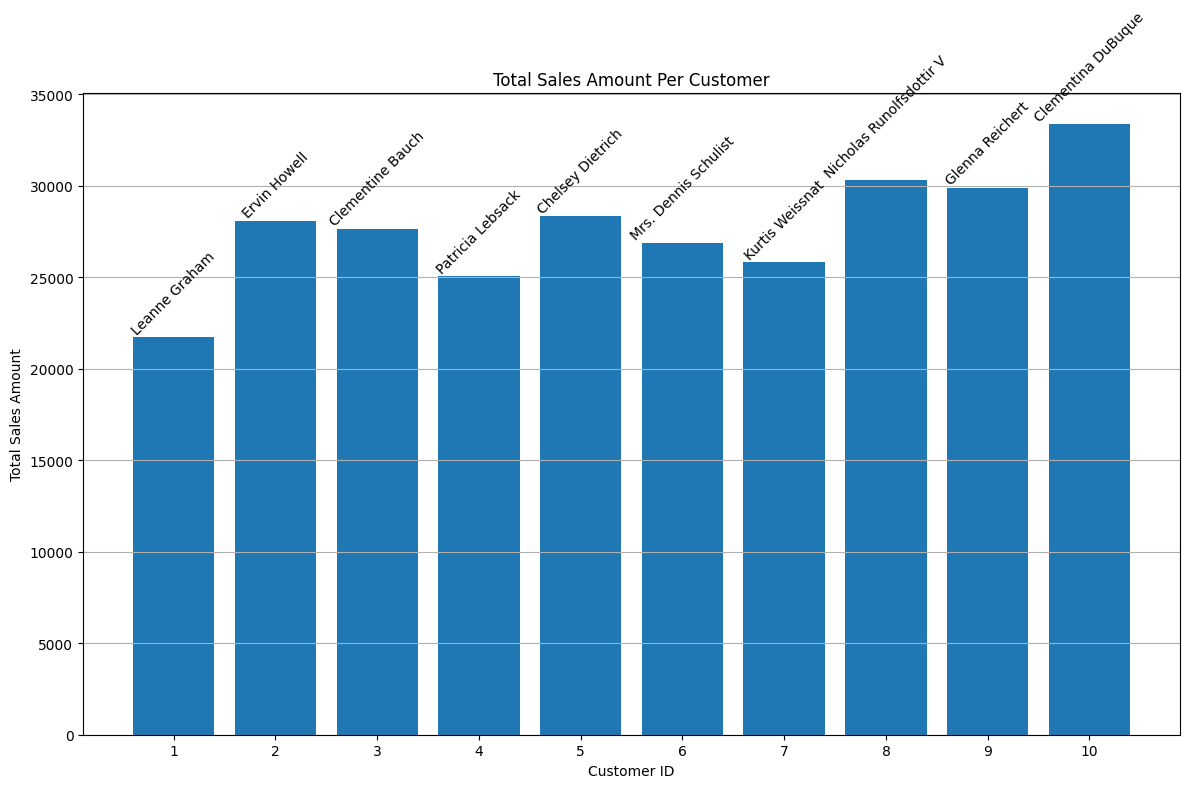

In [26]:
plot_total_sales(final_df)

## Average order quantity

In [27]:
def visualize_average_quantity(df):
    average_order_quantity = df.groupby('product_id')['quantity'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    plt.bar(average_order_quantity['product_id'].astype(str), average_order_quantity['quantity'])
    plt.xlabel('Product ID')
    plt.ylabel('Average Quantity')
    plt.title('Average order quantity per product')
    plt.xticks(average_order_quantity['product_id'].astype(str))
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

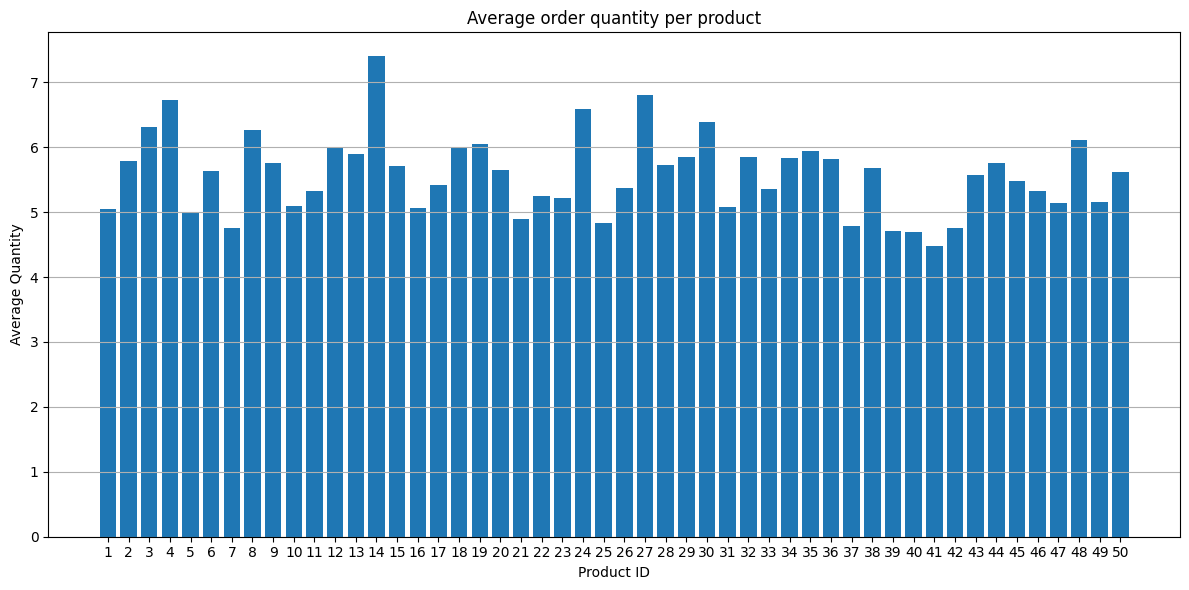

In [28]:
visualize_average_quantity(final_df)

## Find 10 top selling products

In [29]:
def find_top_selling_product(df):
    most_sold_product_quantity = df.groupby('product_id')['quantity'].sum().reset_index()
    most_sold_product_quantity.sort_values('quantity', inplace=True, ascending=False, ignore_index=True)
    top_10_products = most_sold_product_quantity.head(10)
    plt.figure(figsize=(12, 8))
    plt.bar(top_10_products['product_id'].astype(str), top_10_products['quantity'], color='skyblue')
    plt.xlabel('Product ID')
    plt.ylabel('Total Quantity Sold')
    plt.title('Top 10 Most Selling Products')
    plt.xticks(top_10_products['product_id'].astype(str))
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

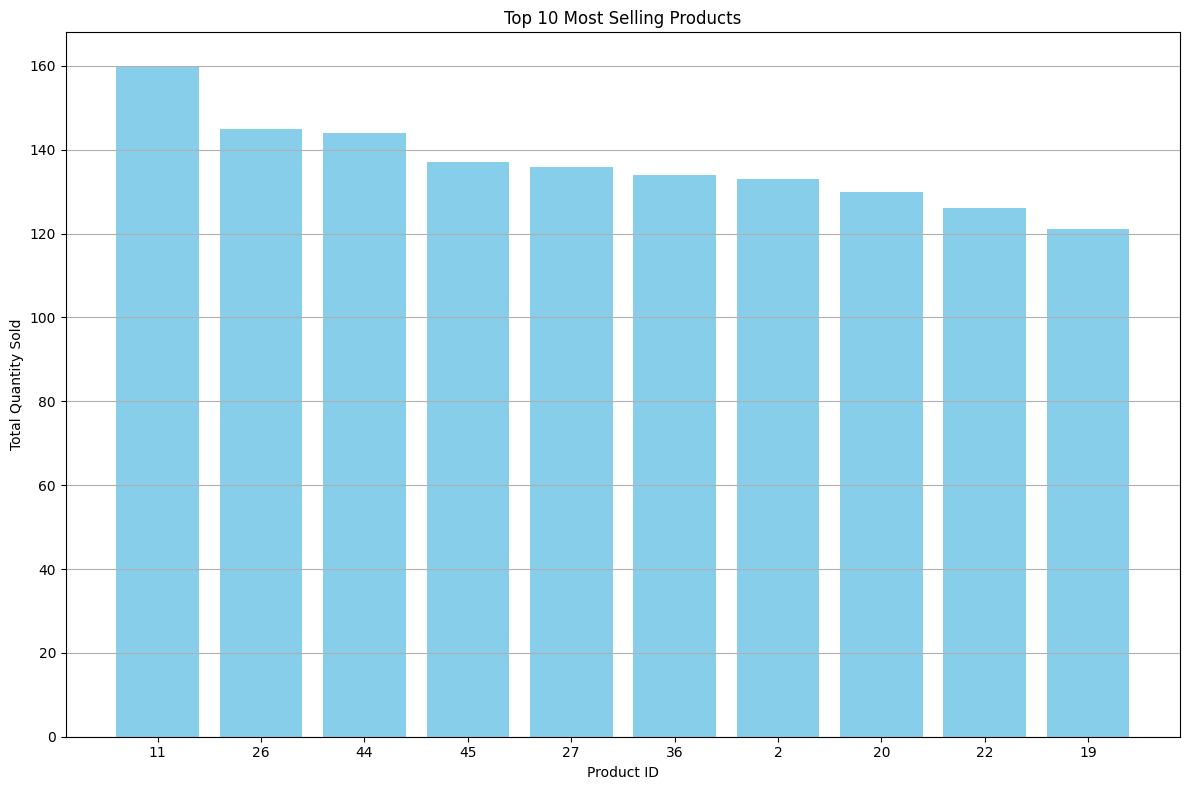

In [30]:
find_top_selling_product(final_df)

## Visualize product sales per months

In [31]:
def visualize_sales_per_month(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    sales_per_month = df.groupby('year_month')['sales_amount'].sum().reset_index()
    
    plt.figure(figsize=(12, 8))
    plt.plot(sales_per_month['year_month'], sales_per_month['sales_amount'], marker='o', linestyle='-')
    plt.xlabel('Year-Month')
    plt.ylabel('Total Sales')
    plt.title('Total Sales Over Months')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

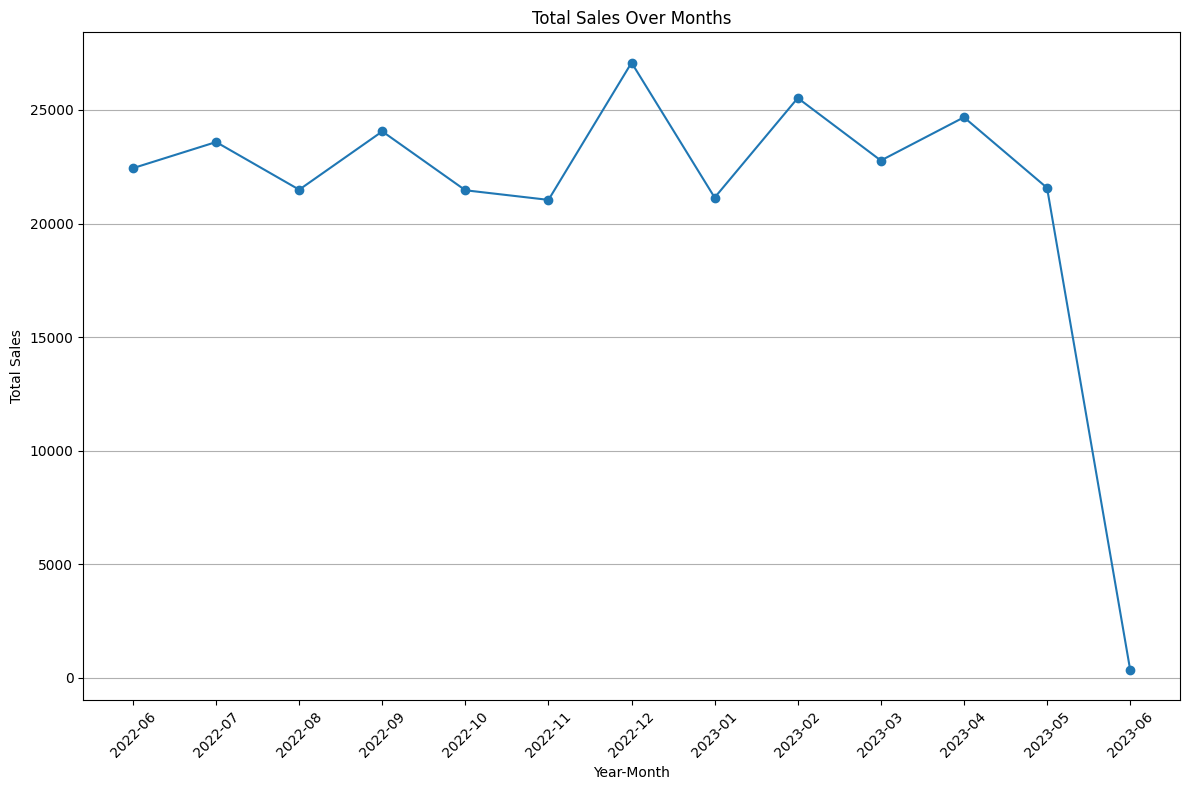

In [32]:
visualize_sales_per_month(final_df)

## Visualize sales per weather condition

In [33]:
def visualize_sales_per_weather_condition(df):
    sales_per_weather = df.groupby('weather')['sales_amount'].sum().reset_index()
    plt.figure(figsize=(12, 8))
    plt.plot(sales_per_weather['weather'], sales_per_weather['sales_amount'], marker='o', linestyle='-')
    plt.xlabel('Weather Condition')
    plt.ylabel('Total Sales')
    plt.title('Total Sales Over weather condition')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()
    

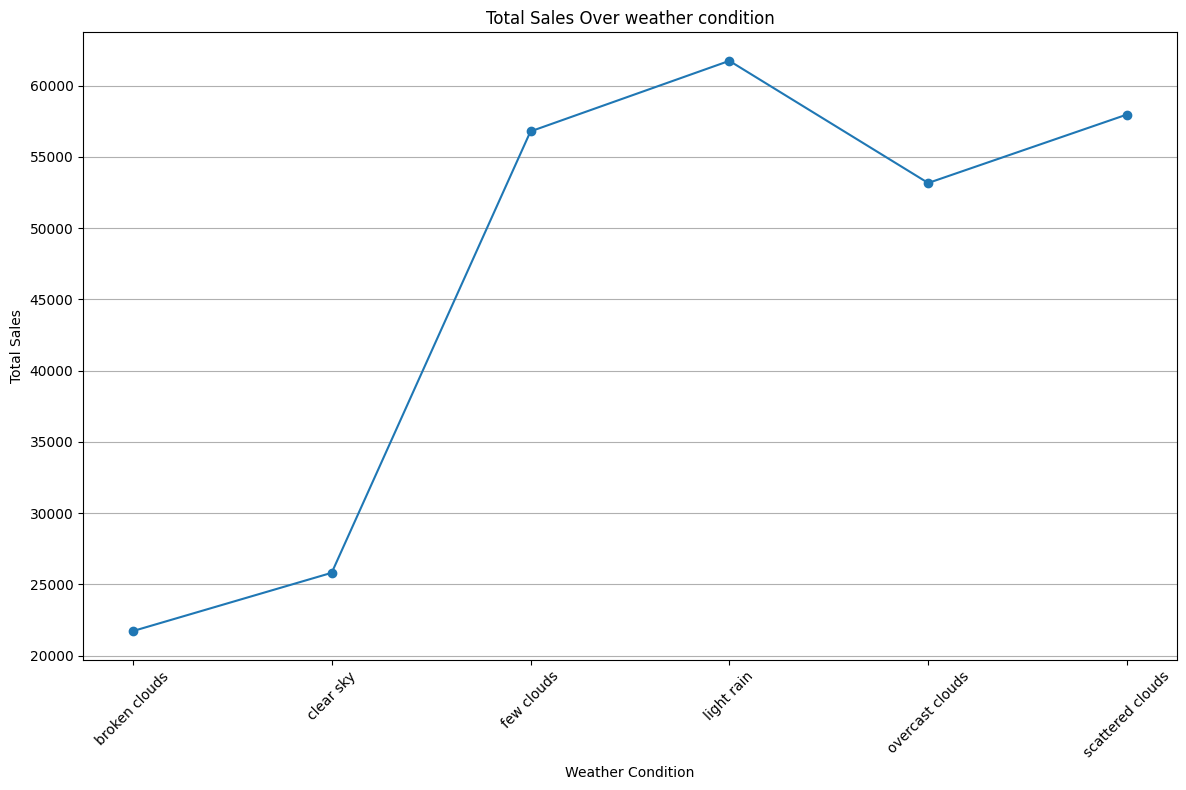

In [34]:
visualize_sales_per_weather_condition(final_df)